In [2]:
import pandas as pd
import numpy as np

In [3]:
precipitation_df=pd.read_csv(r"data\Cuba_Precipitation_with_Nodes (1) (2).csv")
adj_matrix=pd.read_csv(r"data\Adjacency_Matrix______0_80.csv", index_col=0)
precipitation_df["time"]=pd.to_datetime(precipitation_df["time"])
precipitation_df=precipitation_df.sort_values(by=["node", "time"])
precipitation_df.reset_index(drop=True,inplace=True)
nodes=precipitation_df["node"].values
missing_nodes=set(nodes)-set(adj_matrix.index)
precipitation_df["precipitation_diff"]=precipitation_df.groupby("node")["precipitation"].diff()
precip_diff_df=precipitation_df.dropna(subset=["precipitation_diff"])
# precip_values



### STEP 2

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization,Dropout
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



In [19]:
pivot_df = precipitation_df.pivot(index='time', columns='node', values='precipitation')

full_range = pd.date_range(start='1979-01', end='2023-12', freq='M')
pivot_df = pivot_df.reindex(full_range)
pivot_df=pivot_df.fillna(0)

node_id=2
neighbors=adj_matrix.loc[node_id]
linked_nodes=neighbors[neighbors==1].index.tolist()
print(f"Node {node_id} neighbors: {linked_nodes}")
def get_node_series(node_id,precipitation_df):
    return precipitation_df[precipitation_df["node"]==node_id][["time","precipitation_diff"]].reset_index(drop=True)
mode_series=get_node_series(node_id,precipitation_df)
linked_nodes = [int(nb) for nb in linked_nodes]
all_series = [pivot_df[node_id].values]

for nb in linked_nodes:
    all_series.append(pivot_df[nb].values)

X=np.stack(all_series,axis=1)
print(X.shape)
def create_sequences(data,time_index,window_size=90):
    X,y,times=[],[],[]
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size,0])
        times.append(time_index[i+window_size])
    return np.array(X),np.array(y),np.array(times)

x_seq,y_seq,t_seq=create_sequences(X,pivot_df.index)
print(x_seq.shape,y_seq.shape)
num_features=x_seq.shape[2]



Node 2 neighbors: ['1', '3']
(539, 3)
(449, 90, 3) (449,)


C:\Users\gacha\AppData\Local\Temp\ipykernel_3248\2553536754.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_range = pd.date_range(start='1979-01', end='2023-12', freq='M')


In [20]:
scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(pivot_df.values)
scaled_df=pd.DataFrame(scaled_data,index=pivot_df.index,columns=pivot_df.columns)

In [21]:
model=Sequential([
    LSTM(64,input_shape=(30,num_features),return_sequences=False),
    Dense(32,activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam",loss='mse')
model.summary()

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_81 (LSTM)                  │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
train_mask = (t_seq >= pd.to_datetime("1979-01-01")) & (t_seq <= pd.to_datetime("2014-12-31"))
test_mask  = (t_seq >= pd.to_datetime("2015-01-01")) & (t_seq <= pd.to_datetime("2023-12-31"))

X_train, y_train = x_seq[train_mask], y_seq[train_mask]
X_test, y_test   = x_seq[test_mask],  y_seq[test_mask]
history=model.fit(X_train,y_train,
                  validation_data=(X_test,y_test),
                  epochs=50,
                  batch_size=64,
                  verbose=1
                  )




Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 344ms/step - loss: 88.0366 - val_loss: 58.3095
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 84.1950 - val_loss: 56.4368
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 80.1173 - val_loss: 55.2651
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 77.6118 - val_loss: 58.1238
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 77.0573 - val_loss: 59.3679
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 76.3303 - val_loss: 57.8463
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 75.8122 - val_loss: 56.3953
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 75.1547 - val_loss: 55.9820
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 74.8075 - val_loss: 55.2850
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 74.3680 - val_loss: 55.4077
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 74.0071 - val_loss: 54.9755
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 73

In [23]:
loss = model.evaluate(X_test, y_test)
print("Test MSE:", loss)

y_pred = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 71.8397
Test MSE: 71.83969116210938
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


In [10]:
aligned_series = pivot_df[node_id].reindex(t_seq).values

last_value = aligned_series[train_mask][-1]
y_pred_inverse=[]
for diff in y_pred.flatten():
    next_value=last_value+diff
    y_pred_inverse.append(next_value)
    last_value=next_value

y_pred_inverse=np.array(y_pred_inverse)


In [11]:
y_test_inverse=[]
last_value=aligned_series[train_mask][-1]
for diff in y_test.flatten():
    nect_value=last_value+diff
    y_test_inverse.append(next_value)
    last_value=next_value
y_test_inverse=np.array(y_test_inverse)

In [12]:
results_df=pd.DataFrame({
    "date":t_seq[test_mask],
    "node":node_id,
    "actual":y_test_inverse,
    "forecast":y_pred_inverse
})
results_df.to_csv("forecasts_node_{node_id}.csv",index=False)
print("Saved results for Node", node_id)

Saved results for Node 1


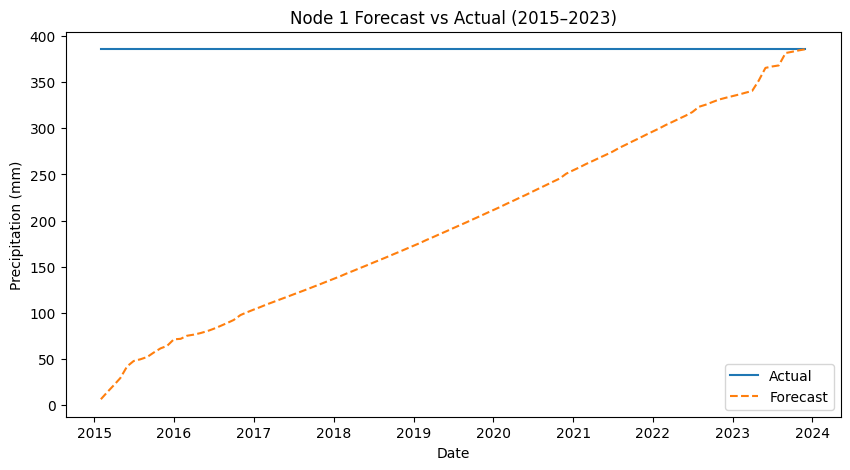

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(t_seq[test_mask], y_test_inverse, label="Actual")
plt.plot(t_seq[test_mask], y_pred_inverse, label="Forecast", linestyle="dashed")
plt.title(f"Node {node_id} Forecast vs Actual (2015–2023)")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.show()

### step 5

In [14]:
class MCDropout(Dropout):
    def call(self,inputs):
        return super().call(inputs,training=True)

In [18]:
scaled_df.columns

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40],
      dtype='int64', name='node')

In [ ]:
all_results=[]

for node_id in scaled_df.columns:  # all 40 nodes
    neighbors = adj_matrix.loc[node_id]
    linked_nodes = neighbors[neighbors==1].index.tolist()
    linked_nodes = [int(nb) for nb in linked_nodes if nb != node_id]  # exclude self

    all_series = [scaled_df[node_id].values]
    for nb in linked_nodes:
        all_series.append(scaled_df[nb].values)

    X = np.stack(all_series, axis=1)
    x_seq, y_seq, t_seq = create_sequences(X, pivot_df.index, window_size=90)
    
    # Split into train/test
    train_mask = (t_seq >= pd.to_datetime("1979-01-01")) & (t_seq <= pd.to_datetime("2014-12-31"))
    test_mask  = (t_seq >= pd.to_datetime("2015-01-01")) & (t_seq <= pd.to_datetime("2023-12-31"))

    X_train, y_train = x_seq[train_mask], y_seq[train_mask]
    X_test, y_test   = x_seq[test_mask], y_seq[test_mask]

    # Train model
    num_features = X_train.shape[2]
    model = Sequential([
        LSTM(64, input_shape=(x_seq.shape[1], num_features), return_sequences=True),
        LSTM(64,return_sequences=False),
        MCDropout(0.3),
        Dense(64,activation="relu", kernel_initializer="he_normal"),
        BatchNormalization(),
        MCDropout(rate=0.3),
        Dense(32,activation="relu",kernel_initializer="he_normal"),
        BatchNormalization(),
        MCDropout(0.3),
        Dense(1, activation="relu")
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    callbacks = [
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        ]
    model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=50, batch_size=64,callbacks=callbacks,verbose=0)

    # Predict
    y_pred_scaled = model.predict(X_test)

    # Inverse diff transformation
    # aligned_series = pivot_df[node_id].reindex(t_seq).values
    # last_value = aligned_series[train_mask][-1]
    # y_pred_inverse = []
    # for diff in y_pred.flatten():
    #     next_value = last_value + diff
    #     y_pred_inverse.append(next_value)
    #     last_value = next_value
    # y_pred_inverse = np.array(y_pred_inverse)

    dummy = np.zeros((len(y_pred_scaled), scaled_df.shape[1]))
    dummy[:,0] = y_pred_scaled.flatten()
    y_pred_inverse = scaler.inverse_transform(dummy)[:,0]

    # Save results
    results_df = pd.DataFrame({
        "date": t_seq[test_mask],
        "node": node_id,
        "forecast": y_pred_inverse
    })
    all_results.append(results_df)

Epoch 1/50


c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - loss: 0.8596 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.5231 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.4851 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.3207 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.3504 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.4067
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.3872 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.3699 - val_loss: 0.0052 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.2792 - val_loss: 0.0052 - learning_rate: 5.0000e-04
Epoch 9/50

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - loss: 0.6547 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.8188 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.6930 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.6185 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.4327 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.5298 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.4797 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.3232 - val_loss: 0.0171 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.3650 - val_loss: 0.0171 - learning_rate: 5.0000e-04
Epoch 9/5

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - loss: 1.4226 - val_loss: 0.0161 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.7715 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.5558 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.6142 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.5543 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.3932
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.4212 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.4377 - val_loss: 0.0161 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.4714 - val_loss: 0.0163 - learning_rate: 5.0000e-04
Epoch 9/5

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - loss: 0.7891 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 0.7375 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.6783 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 0.5159 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.5399 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2822
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.3014 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.3728 - val_loss: 0.0133 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.2197 - val_loss: 0.0133 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 375ms/step - loss: 1.1856 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 0.7229 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.7579 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.4742 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.5213 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.4612
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.3386 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.3195 - val_loss: 0.0122 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.4936 - val_loss: 0.0122 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - loss: 0.8748 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.7602 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.5885 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.5282 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.5197 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.4442
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.4164 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.4147 - val_loss: 0.0061 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.3011 - val_loss: 0.0061 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 402ms/step - loss: 0.9946 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - loss: 0.6428 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.5499 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.5138 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 0.3991 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.3516
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.3756 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 0.3391 - val_loss: 0.0082 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.4005 - val_loss: 0.0082 - learning_rate: 5.0000e-04
Epoch 9/

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - loss: 0.7870 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 0.6553 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.7194 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.5231 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.4814 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.4744
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.4557 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.3931 - val_loss: 0.0114 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 0.4571 - val_loss: 0.0114 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - loss: 1.2896 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.9410 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.7775 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.8980 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.5385 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.6076
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.5709 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 0.5616 - val_loss: 0.0271 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 0.5653 - val_loss: 0.0271 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step - loss: 0.8129 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.5450 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.7147 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.4533 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.3831 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.2962
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.2971 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.3655 - val_loss: 0.0068 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.2721 - val_loss: 0.0068 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - loss: 0.6222 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.5810 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.4006 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.4138 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.3281 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2523
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.2449 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.2801 - val_loss: 0.0037 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.2870 - val_loss: 0.0037 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - loss: 0.8144 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.7519 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.5305 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.4830 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.3838 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.4239
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.4382 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.3603 - val_loss: 0.0123 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.2679 - val_loss: 0.0123 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - loss: 0.8526 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - loss: 0.8453 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.6260 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.5927 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.5056 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.3857
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.3710 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.4024 - val_loss: 0.0080 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.2783 - val_loss: 0.0080 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - loss: 0.7282 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.4851 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.4806 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.4629 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.4291 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4373
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.4286 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.3280 - val_loss: 0.0042 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.3131 - val_loss: 0.0042 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - loss: 0.8079 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.6683 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.5607 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.5270 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.5270 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.4141
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.3914 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.3638 - val_loss: 0.0087 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.4319 - val_loss: 0.0087 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 487ms/step - loss: 1.3376 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 0.9126 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 0.6937 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.6207 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.5076 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.4831
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 0.4642 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.6331 - val_loss: 0.0336 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.3635 - val_loss: 0.0336 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - loss: 0.6917 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 0.5333 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.6274 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.4985 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.3826 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.5376
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.4680 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.2950 - val_loss: 0.0343 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 0.3471 - val_loss: 0.0343 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - loss: 0.8333 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.7169 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 0.7245 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.8023 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.6823 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.4872 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.5021 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.3345 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.3875
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.000500000023748

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - loss: 0.8768 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - loss: 0.8964 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.6617 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 0.6569 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 0.5180 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.4843
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 0.4913 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.4243 - val_loss: 0.0027 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.3621 - val_loss: 0.0027 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 389ms/step - loss: 0.9876 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.8610 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.7259 - val_loss: 0.0289 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.7955 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 0.6428 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.4935
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.5338 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.4071 - val_loss: 0.0301 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.3378 - val_loss: 0.0301 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 444ms/step - loss: 0.8560 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.7737 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.4531 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.6560 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.6370 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.6280
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.5802 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.3375 - val_loss: 0.0293 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - loss: 0.5496 - val_loss: 0.0294 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 416ms/step - loss: 0.6293 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.7003 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 0.5249 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 0.3908 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.4374 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2967
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.2834 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.3628 - val_loss: 0.0276 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.2538 - val_loss: 0.0276 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 404ms/step - loss: 1.0895 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 0.9317 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 0.7224 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.6519 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.5839 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.6531
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.6575 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.4448 - val_loss: 0.0301 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.3590 - val_loss: 0.0301 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 376ms/step - loss: 1.1814 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 1.0075 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.7857 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.8416 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - loss: 0.5515 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.4530
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - loss: 0.5050 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.5624 - val_loss: 0.0310 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.4773 - val_loss: 0.0310 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - loss: 0.7672 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.6720 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.5891 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.5236 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.4450 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.3901 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.3929 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.2894 - val_loss: 0.0302 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.3519 - val_loss: 0.0302 - learning_rate: 5.0000e-0

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - loss: 0.9167 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.6644 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.6258 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.4700 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.4729 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.3793
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.3683 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.3836 - val_loss: 0.0304 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 0.3615 - val_loss: 0.0304 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 397ms/step - loss: 0.8609 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 0.9105 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.9644 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.6950 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - loss: 0.5480 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.4626
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - loss: 0.4312 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.4423 - val_loss: 0.0288 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.4128 - val_loss: 0.0288 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 452ms/step - loss: 0.9691 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.8620 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - loss: 0.6555 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - loss: 0.7247 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 0.6027 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.5076
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.5596 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.5092 - val_loss: 0.0285 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 0.3888 - val_loss: 0.0285 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 444ms/step - loss: 0.6907 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.7692 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - loss: 0.6188 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.4824 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.4055 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.4288
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.4035 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 0.2886 - val_loss: 0.0302 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.3443 - val_loss: 0.0302 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 404ms/step - loss: 1.1903 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.8310 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.8763 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.5999 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 0.4262 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.5513
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.5499 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.4935 - val_loss: 0.0302 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.4002 - val_loss: 0.0302 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 442ms/step - loss: 1.3903 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - loss: 1.0826 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.7249 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - loss: 0.6103 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.5014 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.5007
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.4582 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.3956 - val_loss: 0.0294 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.4693 - val_loss: 0.0295 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 506ms/step - loss: 0.6176 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - loss: 0.5274 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.4663 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.3770 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - loss: 0.3149 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.2381
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.2398 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - loss: 0.2843 - val_loss: 0.0300 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: 0.2396 - val_loss: 0.0303 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - loss: 0.7433 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.8270 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.5080 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.4769 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.4047 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.4566
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.4114 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.2469 - val_loss: 0.0319 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.3363 - val_loss: 0.0319 - learning_rate: 5.0000e-04
Epoch 9/5

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - loss: 0.8341 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.5770 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.5167 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.3921 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.4049 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.2971 
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.3641 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.3861 - val_loss: 0.0354 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.3309 - val_loss: 0.0354 - learning_rate: 5.0000e-04
Epoch 9/5

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 525ms/step - loss: 0.7987 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.6188 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - loss: 0.6587 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.6049 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.5366 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.4138
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 0.4138 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.4014 - val_loss: 0.0354 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.4292 - val_loss: 0.0354 - learning_rate: 5.0000e-04
Epoch 9/5

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step - loss: 0.9328 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.9048 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.6758 - val_loss: 0.0272 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.6351 - val_loss: 0.0271 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.4906 - val_loss: 0.0269 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.5579
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - loss: 0.5533 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - loss: 0.3740 - val_loss: 0.0269 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.3771 - val_loss: 0.0270 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 428ms/step - loss: 0.6606 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.6587 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.5164 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.4743 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 0.3959 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2572
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - loss: 0.2655 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - loss: 0.3284 - val_loss: 0.0067 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.3154 - val_loss: 0.0067 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 423ms/step - loss: 1.2998 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.7941 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.8189 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.6756 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.6582 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.5232
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 0.5366 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.5344 - val_loss: 0.0064 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.5271 - val_loss: 0.0064 - learning_rate: 5.0000e-

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - loss: 0.9958 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.8551 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.6199 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.5909 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.5325 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.5783
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.5179 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.4829 - val_loss: 0.0078 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.3686 - val_loss: 0.0078 - learning_rate: 5.0000e-04
Epoch 9/

c:\Users\gacha\PycharmProjects\graph-lstms-for weather predictions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - loss: 0.9832 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 1.0428 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - loss: 0.6907 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.6294 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.5755 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.4554
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.4253 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.3741 - val_loss: 0.0139 - learning_rate: 5.0000e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.3128 - val_loss: 0.0139 - learning_rate: 5.0000e-

In [16]:
final_results=pd.concat(all_results)
final_results.to_csv("forecast_all_nodes.csv", index=False)
print("Saved")

Saved


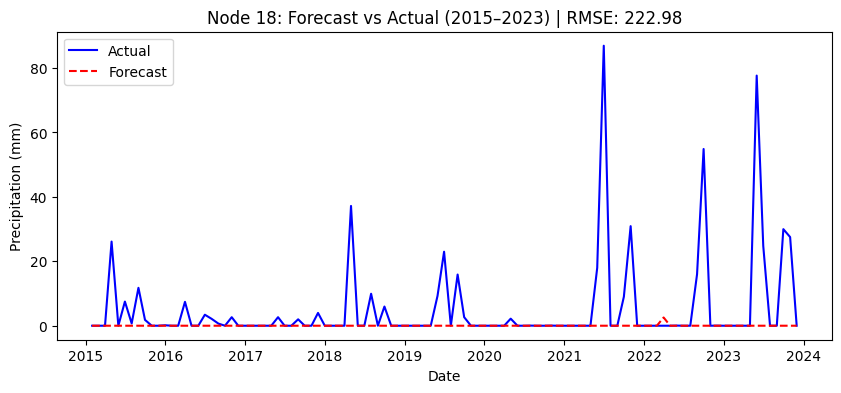

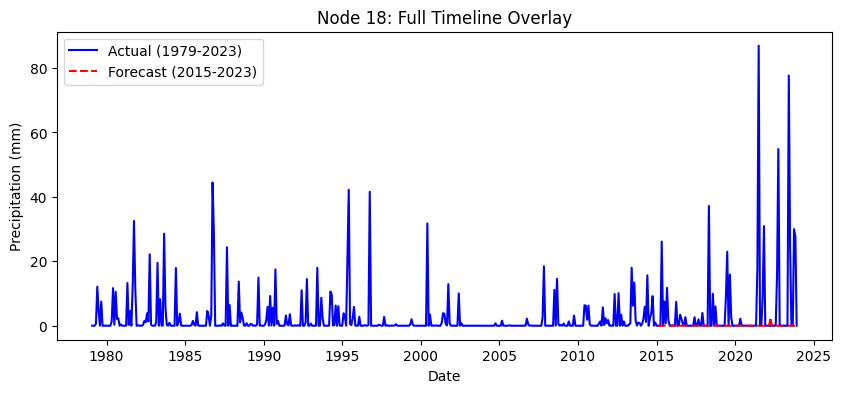

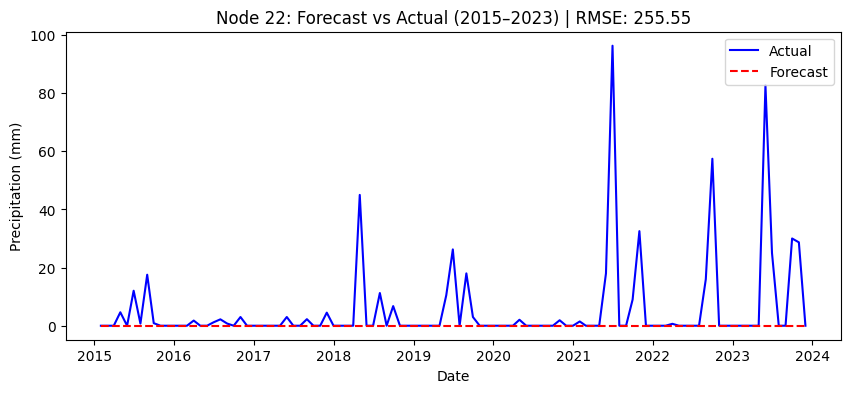

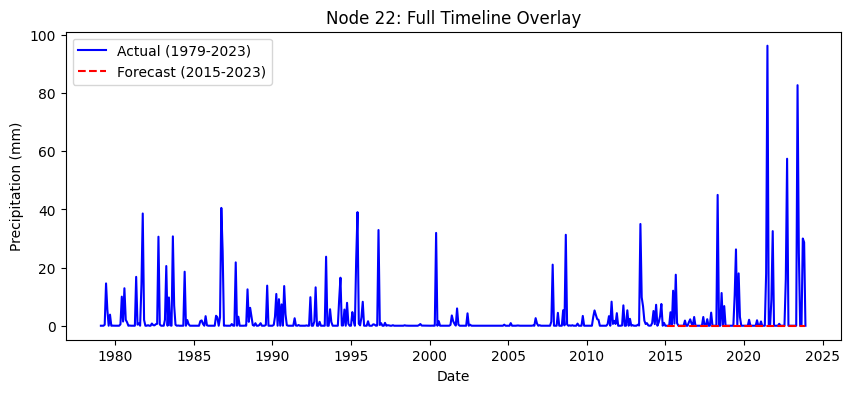

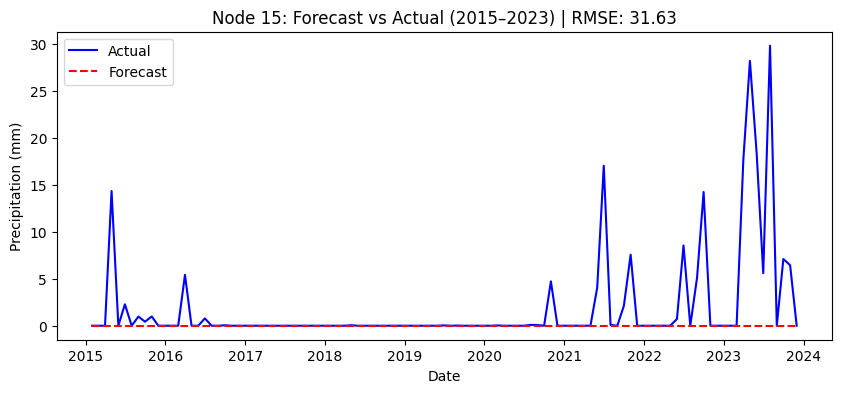

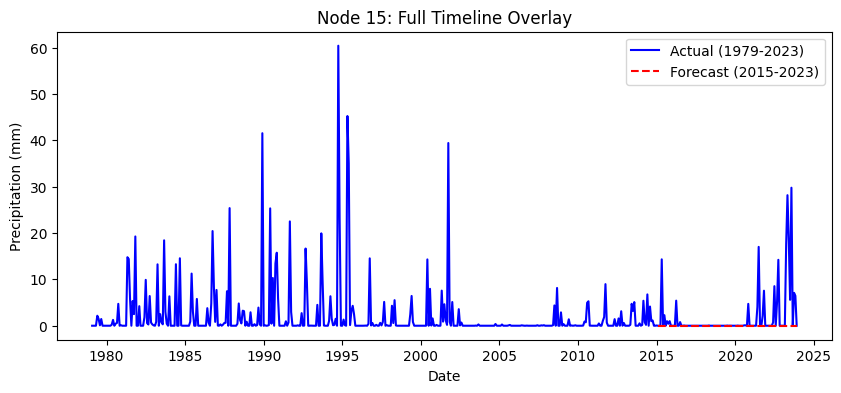

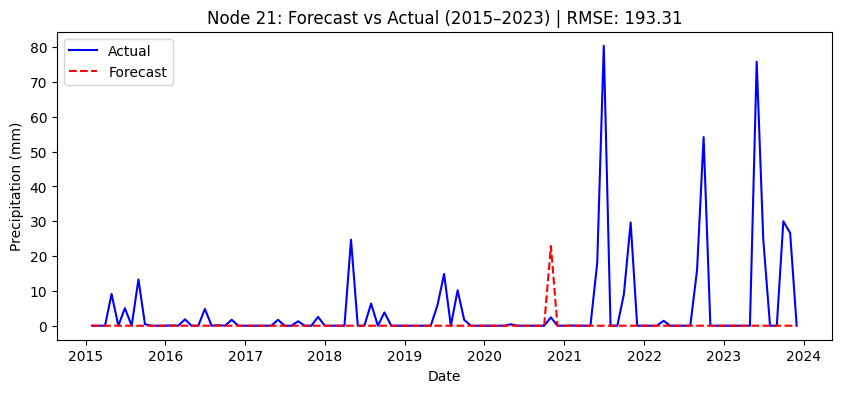

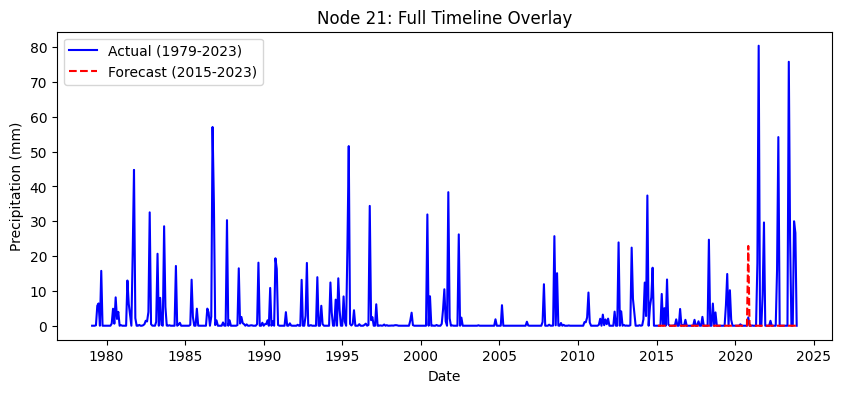

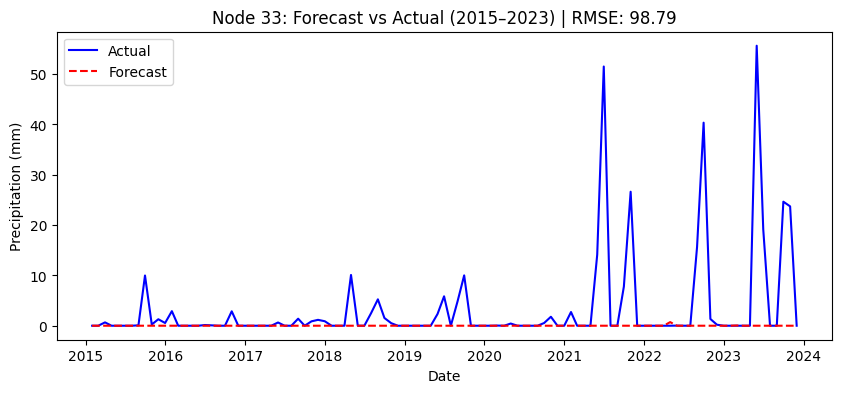

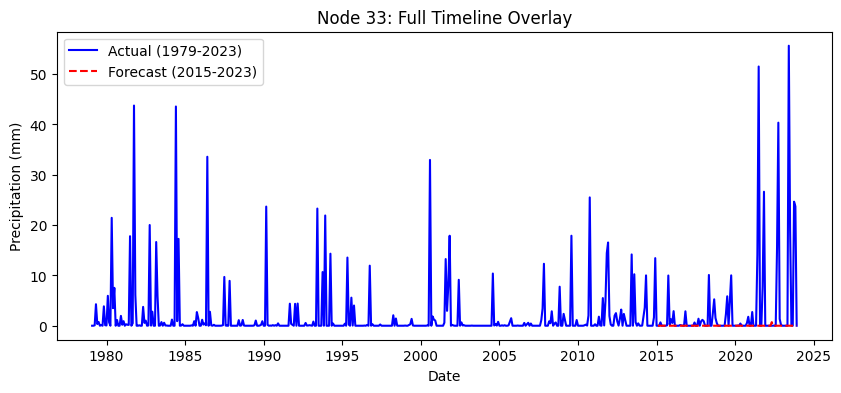

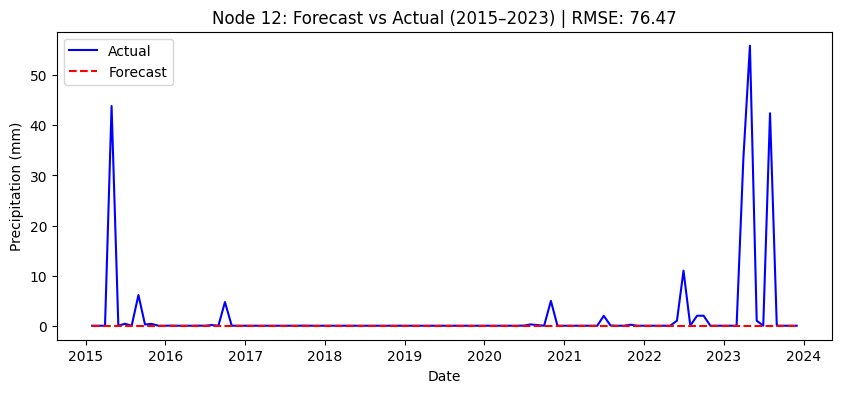

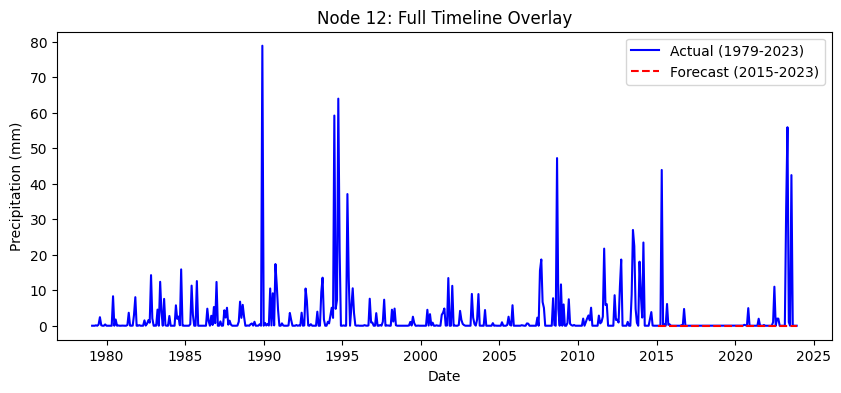

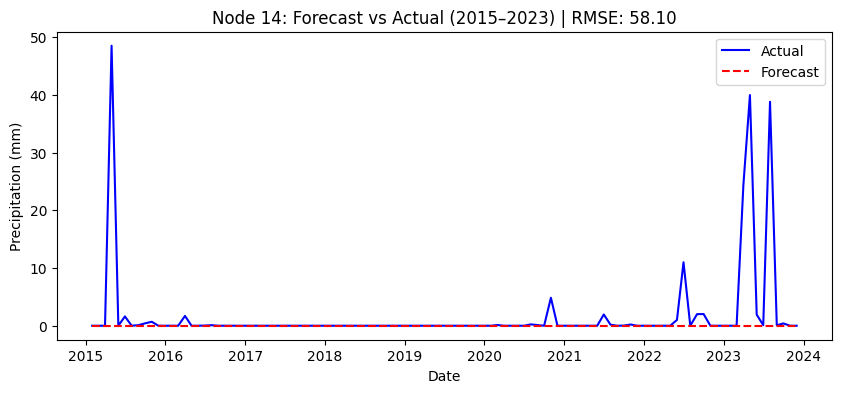

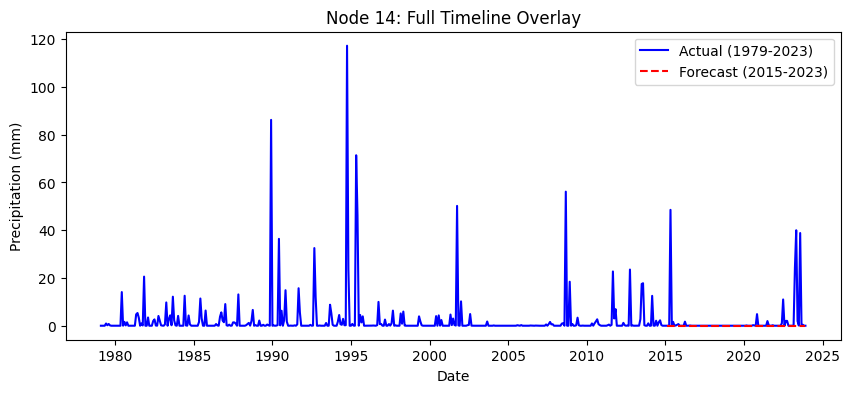

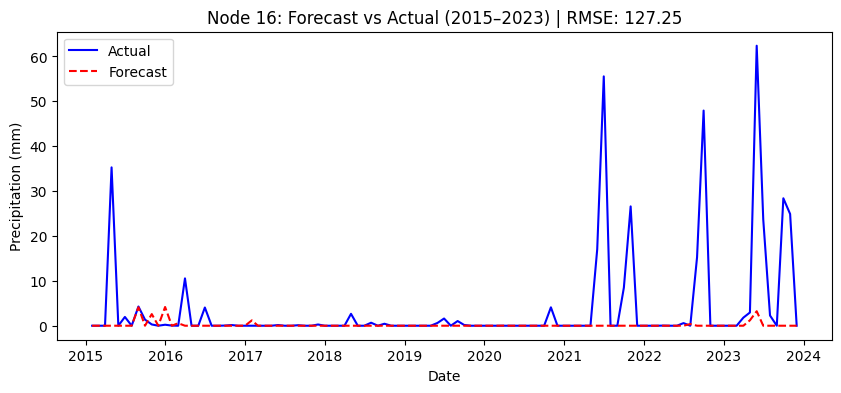

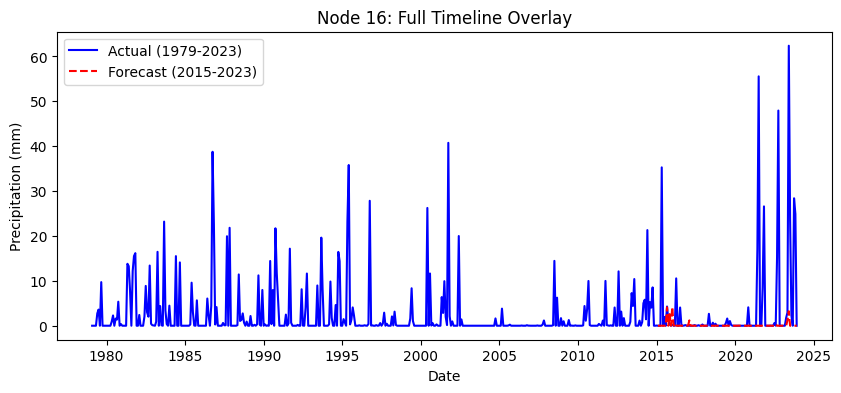

RMSE for selected nodes: {np.int64(18): 222.9780605718288, np.int64(22): 255.54772998887367, np.int64(15): 31.633486876043555, np.int64(21): 193.3098393283863, np.int64(33): 98.79121106231975, np.int64(12): 76.46803672551707, np.int64(14): 58.09886710552451, np.int64(16): 127.24606679647144}


In [17]:
test_nodes = np.random.choice(final_results['node'].unique(), size=8, replace=False)
rmse_dict = {}

for node_id in test_nodes:
    node_df = final_results[final_results['node'] == node_id].copy()
    
    # Get actual series from pivot_df
    actual_series = pivot_df[node_id].reindex(node_df['date']).values
    
    # Compute RMSE
    rmse = mean_squared_error(actual_series, node_df['forecast'])
    # rmse=np.sqrt(mse)
    rmse_dict[node_id] = rmse
    
    # Forecast vs Actual (2015–2023)
    plt.figure(figsize=(10,4))
    plt.plot(node_df['date'], actual_series, label='Actual', color='blue')
    plt.plot(node_df['date'], node_df['forecast'], label='Forecast', linestyle='dashed', color='red')
    plt.title(f'Node {node_id}: Forecast vs Actual (2015–2023) | RMSE: {rmse:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.legend()
    plt.show()
    
    # Full timeline overlay (1979–2023)
    full_actual = pivot_df[node_id]
    plt.figure(figsize=(10,4))
    plt.plot(full_actual.index, full_actual.values, label='Actual (1979-2023)', color='blue')
    plt.plot(node_df['date'], node_df['forecast'], label='Forecast (2015-2023)', color='red', linestyle='dashed')
    plt.title(f'Node {node_id}: Full Timeline Overlay')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.legend()
    plt.show()

print("RMSE for selected nodes:", rmse_dict)